In [1]:
import time
import sys
sys.path.append('../')
import sharead as transformer_ad
import pandas as pd
import pickle as pk
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import itertools
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf

import random
import torch
import os
import gc

2024-08-30 15:14:49.673543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 15:14:49.695833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 15:14:49.702559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 15:14:49.718684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 15:14:50.776175: W tensorflow/comp

In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
#tf.set_random_seed(seed)

# Evaluation Code

In [3]:
def shift(arr, num, fill_value=np.nan):
    arr = np.roll(arr, num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr
def filter_pred(values_pred, scale=3):
    predicted_anomalies_ = np.argwhere(values_pred == 1).ravel()
    predicted_anomalies_shift_forward = shift(predicted_anomalies_, 1, fill_value=predicted_anomalies_[0])
    predicted_anomalies_shift_backward = shift(predicted_anomalies_, -1, fill_value=predicted_anomalies_[-1])
    predicted_anomalies_start = np.argwhere(
        (predicted_anomalies_shift_forward - predicted_anomalies_) != -1
    ).ravel()
    predicted_anomalies_finish = np.argwhere(
        (predicted_anomalies_ - predicted_anomalies_shift_backward) != -1
    ).ravel()
    predicted_anomalies = np.hstack(
        [
            predicted_anomalies_[predicted_anomalies_start].reshape(-1, 1),
            predicted_anomalies_[predicted_anomalies_finish].reshape(-1, 1),
        ]
    )
    for a_range in predicted_anomalies:
        if a_range[1]-a_range[0]<=scale-1:
            values_pred[a_range[0]:a_range[1]+1] = 0
    return values_pred

from prts import ts_precision, ts_recall, ts_fscore
def bf_search(label, score, verbose=True, is_filter=False):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    start = 90
    search_range = [np.percentile(score, q) for q in np.arange(start, 100, 0.1)]
    m = {'f1-score':-1., 'precision':-1., 'recall':-1.}
    m_t = 0.0
    #print(len(score))
    #print(len(search_range))
    for threshold in sorted(search_range)[::-1]:
        real = label
        pred = score > threshold
        #print(np.unique(pred))
        if is_filter:
            pred = filter_pred(pred, scale=1)
        #pred = filter_pred(pred, scale=3)
        if len(np.unique(pred))==1:
            continue
        target = ts_fscore(real, pred, beta=1.0, p_alpha=0.0, r_alpha=0.5, cardinality="reciprocal", p_bias="front", r_bias="front")
        if target > m['f1-score']:
            m_t = threshold
            m['f1-score'] = target
            m['precision'] = ts_precision(real, pred, alpha=0.0, cardinality="reciprocal", bias="front")
            m['recall'] = ts_recall(real, pred, alpha=0.5, cardinality="reciprocal", bias="front")
            if verbose:
                print("cur thr: ", threshold, target, m, m_t)
    #print(m, m_t)
    return m, m_t

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.

    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall

def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False,
                    is_filter=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.

    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):

    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
        if is_filter:
            predict = filter_pred(predict, scale=1)
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
            anomaly_state = True
            anomaly_count += 1
            for j in range(i, 0, -1):
                if not actual[j]:
                    break
                else:
                    if not predict[j]:
                        predict[j] = True
                        latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

def bf_search_omni(label, score, verbose=True, is_filter=False):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    start = 90
    search_range = [np.percentile(score, q) for q in np.arange(start, 100, 0.1)]
    m = {'f1-score':-1., 'precision':-1., 'recall':-1.}
    m_t = 0.0
    #print(len(score))
    #print(len(search_range))
    for threshold in sorted(search_range)[::-1]:
        real = label
        pred = adjust_predicts(score, label, threshold, is_filter=is_filter)
        #print(np.unique(pred))
        if len(np.unique(pred))==1:
            continue
        target = calc_point2point(pred, label)
        if target[0] > m['f1-score']:
            m_t = threshold
            m['f1-score'] = target[0]
            m['precision'] = target[1]
            m['recall'] = target[2]
            if verbose:
                print("cur thr: ", threshold, target, m, m_t)
    #print(m, m_t)
    return m, m_t

In [4]:
def ap_rangebased(label, score, is_filter=False):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    start = 0
    search_range = [np.percentile(score, q) for q in np.arange(start, 100, 0.1)]
    m = {}
    m['precision'] = []
    m['recall'] = []
    for threshold in sorted(search_range):
        real = label
        pred = score > threshold
        #print(np.unique(pred))
        if is_filter:
            pred = filter_pred(pred, scale=1)
        #pred = filter_pred(pred, scale=3)
        if len(np.unique(pred))==1:
            continue
        m['precision'].append(ts_precision(real, pred, alpha=0.0, cardinality="reciprocal", bias="front"))
        m['recall'].append(ts_recall(real, pred, alpha=0.5, cardinality="reciprocal", bias="front"))
    # The last precision and recall values are 1. and 0
    m['precision'].append(1)
    m['recall'].append(0)
    ap = -np.sum(np.diff(m['recall']) * np.array(m['precision'])[1:])
    #print(m, ap)
    #print(ap)
    return ap

def ap_pointadjust(label, score, is_filter=False):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    start = 0
    search_range = [np.percentile(score, q) for q in np.arange(start, 100, 0.1)]
    m = {}
    m['precision'] = []
    m['recall'] = []
    for threshold in sorted(search_range):
        real = label
        pred = adjust_predicts(score, label, threshold, is_filter=is_filter)
        #print(np.unique(pred))
        if len(np.unique(pred))==1:
            continue
        target = calc_point2point(pred, label)
        m['precision'].append(target[1])
        m['recall'].append(target[2])
    # The last precision and recall values are 1. and 0
    m['precision'].append(1)
    m['recall'].append(0)
    ap = -np.sum(np.diff(m['recall']) * np.array(m['precision'])[1:])
    #print(m, ap)
    #print(ap)
    return ap

# Set the Hyper-parameters and Load the Data

In [5]:
datafiles = sorted(os.listdir('../CTF_data/CTF_data'))

In [6]:
datafiles.pop(0)

'.ipynb_checkpoints'

In [7]:
# ip with missing files
datafiles = [f for f in datafiles if '118' not in f and '166' not in f and '174' not in f and '263' not in f and '289' not in f and '307' not in f and '419' not in f and '432' not in f]

In [8]:
#name='iterate-huber-nosfa-nolongterm-ep30-1e-4-noisy'
lr=1e-4
num_epochs=5
sequence_length = 100
z_dim = 16
batch_size = 128
gpu_choice = 0
use_sfa = False
no_longterm = True
no_featerm = False
noisy_rate = 0
loss_func = 'huber'


In [9]:
name = 'transformer_ad'
name += '-'
name += loss_func
name += '-'
if use_sfa:
    name += 'usesfa'
    name += '-'
else:
    name += 'nosfa'
    name += '-'
if no_longterm:
    name += 'nolongterm'
    name += '-'
else:
    name += 'uselongterm'
    name += '-'
if no_featerm:
    name += 'nofeaterm'
    name += '-'
else:
    name += 'usefeaterm'
    name += '-'
name += 'ep'
name += str(num_epochs)
name += '-'
name += 'z'
name += str(z_dim)
name += '-'
if noisy_rate != 0:
    name += 'noisy'
    name += str(noisy_rate)
    name += '-'
else:
    name += 'nonoisy'
basename = name
name += time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()) 
print(basename)

transformer_ad-huber-nosfa-nolongterm-usefeaterm-ep5-z16-nonoisy


In [10]:
dataset = transformer_ad.MonitorEntityDataset(datafiles, sequence_length, z_dim, gpu=gpu_choice, use_sfa=use_sfa, no_longterm=no_longterm, prefix='../CTF_data/CTF_data/')

# Train and Evaluate the Model

Epoch [5/5], Iter [26220/26273], total_loss: 0.0818
valid_loss: [0.08988163129203498, 0.08380886265357626, 0.08650101025263614, 0.09149155519916327]


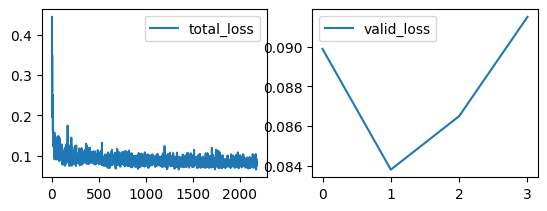

 80%|████████  | 4/5 [54:42<13:40, 820.52s/it]

early stoppong


0


100%|██████████| 23/23 [00:00<00:00, 29.67it/s]


1


100%|██████████| 23/23 [00:00<00:00, 29.52it/s]


10


100%|██████████| 23/23 [00:00<00:00, 29.44it/s]


100


100%|██████████| 23/23 [00:00<00:00, 29.44it/s]


101


100%|██████████| 23/23 [00:00<00:00, 29.46it/s]


102


100%|██████████| 23/23 [00:00<00:00, 29.20it/s]


103


100%|██████████| 23/23 [00:00<00:00, 29.16it/s]


104


100%|██████████| 23/23 [00:00<00:00, 29.04it/s]


105


100%|██████████| 23/23 [00:00<00:00, 29.15it/s]


106


100%|██████████| 23/23 [00:00<00:00, 29.42it/s]


107


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


108


100%|██████████| 23/23 [00:00<00:00, 29.25it/s]


109


100%|██████████| 23/23 [00:00<00:00, 29.21it/s]


11


100%|██████████| 23/23 [00:00<00:00, 28.98it/s]


110


100%|██████████| 23/23 [00:00<00:00, 28.93it/s]


111


100%|██████████| 23/23 [00:00<00:00, 28.85it/s]


112


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


113


100%|██████████| 23/23 [00:00<00:00, 29.12it/s]


114


100%|██████████| 23/23 [00:00<00:00, 28.77it/s]


115


100%|██████████| 23/23 [00:00<00:00, 28.92it/s]


116


100%|██████████| 23/23 [00:00<00:00, 28.60it/s]


117


100%|██████████| 23/23 [00:00<00:00, 28.71it/s]


119


100%|██████████| 23/23 [00:00<00:00, 29.08it/s]


12


100%|██████████| 23/23 [00:00<00:00, 28.91it/s]


120


100%|██████████| 23/23 [00:00<00:00, 28.83it/s]


121


100%|██████████| 23/23 [00:00<00:00, 28.55it/s]


122


100%|██████████| 23/23 [00:00<00:00, 28.93it/s]


123


100%|██████████| 23/23 [00:00<00:00, 28.82it/s]


124


100%|██████████| 23/23 [00:00<00:00, 29.28it/s]


125


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


126


100%|██████████| 23/23 [00:00<00:00, 28.93it/s]


127


100%|██████████| 23/23 [00:00<00:00, 28.99it/s]


128


100%|██████████| 23/23 [00:00<00:00, 28.77it/s]


129


100%|██████████| 23/23 [00:00<00:00, 29.53it/s]


13


100%|██████████| 23/23 [00:00<00:00, 28.93it/s]


130


100%|██████████| 23/23 [00:00<00:00, 28.91it/s]


131


100%|██████████| 23/23 [00:00<00:00, 28.97it/s]


132


100%|██████████| 23/23 [00:00<00:00, 29.45it/s]


133


100%|██████████| 23/23 [00:00<00:00, 29.57it/s]


134


100%|██████████| 23/23 [00:00<00:00, 28.50it/s]


135


100%|██████████| 23/23 [00:00<00:00, 29.20it/s]


136


100%|██████████| 23/23 [00:00<00:00, 29.30it/s]


137


100%|██████████| 23/23 [00:00<00:00, 29.08it/s]


138


100%|██████████| 23/23 [00:00<00:00, 29.01it/s]


139


100%|██████████| 23/23 [00:00<00:00, 29.13it/s]


14


100%|██████████| 23/23 [00:00<00:00, 28.04it/s]


140


100%|██████████| 23/23 [00:00<00:00, 29.16it/s]


141


100%|██████████| 23/23 [00:00<00:00, 28.90it/s]


142


100%|██████████| 23/23 [00:00<00:00, 28.32it/s]


143


100%|██████████| 23/23 [00:00<00:00, 27.73it/s]


144


100%|██████████| 23/23 [00:00<00:00, 27.03it/s]


145


100%|██████████| 23/23 [00:00<00:00, 28.89it/s]


146


100%|██████████| 23/23 [00:00<00:00, 27.44it/s]


147


100%|██████████| 23/23 [00:00<00:00, 26.10it/s]


148


100%|██████████| 23/23 [00:01<00:00, 19.48it/s]


149


100%|██████████| 23/23 [00:00<00:00, 28.24it/s]


15


100%|██████████| 23/23 [00:01<00:00, 20.79it/s]


150


100%|██████████| 23/23 [00:01<00:00, 18.58it/s]


151


100%|██████████| 23/23 [00:00<00:00, 29.92it/s]


152


100%|██████████| 23/23 [00:01<00:00, 19.66it/s]


153


100%|██████████| 23/23 [00:00<00:00, 27.67it/s]


154


100%|██████████| 23/23 [00:00<00:00, 25.54it/s]


155


100%|██████████| 23/23 [00:00<00:00, 27.48it/s]


156


100%|██████████| 23/23 [00:00<00:00, 27.98it/s]


157


100%|██████████| 23/23 [00:00<00:00, 28.74it/s]


158


100%|██████████| 23/23 [00:00<00:00, 27.51it/s]


159


100%|██████████| 23/23 [00:00<00:00, 27.26it/s]


16


100%|██████████| 23/23 [00:00<00:00, 29.07it/s]


160


100%|██████████| 23/23 [00:00<00:00, 27.72it/s]


161


100%|██████████| 23/23 [00:00<00:00, 28.05it/s]


162


100%|██████████| 23/23 [00:00<00:00, 28.31it/s]


163


100%|██████████| 23/23 [00:00<00:00, 28.67it/s]


164


100%|██████████| 23/23 [00:00<00:00, 28.27it/s]


165


100%|██████████| 23/23 [00:00<00:00, 28.03it/s]


167


100%|██████████| 23/23 [00:00<00:00, 27.82it/s]


168


100%|██████████| 23/23 [00:00<00:00, 28.13it/s]


169


100%|██████████| 23/23 [00:00<00:00, 29.06it/s]


17


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


170


100%|██████████| 23/23 [00:00<00:00, 28.40it/s]


171


100%|██████████| 23/23 [00:00<00:00, 29.17it/s]


172


100%|██████████| 23/23 [00:00<00:00, 28.46it/s]


173


100%|██████████| 23/23 [00:00<00:00, 28.25it/s]


175


100%|██████████| 23/23 [00:00<00:00, 27.73it/s]


176


100%|██████████| 23/23 [00:00<00:00, 27.15it/s]


177


100%|██████████| 23/23 [00:00<00:00, 26.09it/s]


178


100%|██████████| 23/23 [00:00<00:00, 25.70it/s]


179


100%|██████████| 23/23 [00:00<00:00, 26.54it/s]


18


100%|██████████| 23/23 [00:00<00:00, 27.48it/s]


180


100%|██████████| 23/23 [00:00<00:00, 27.19it/s]


181


100%|██████████| 23/23 [00:00<00:00, 26.37it/s]


182


100%|██████████| 23/23 [00:00<00:00, 26.68it/s]


183


100%|██████████| 23/23 [00:00<00:00, 28.66it/s]


184


100%|██████████| 23/23 [00:00<00:00, 27.36it/s]


185


100%|██████████| 23/23 [00:00<00:00, 28.04it/s]


186


100%|██████████| 23/23 [00:00<00:00, 27.68it/s]


187


100%|██████████| 23/23 [00:00<00:00, 28.24it/s]


188


100%|██████████| 23/23 [00:00<00:00, 28.99it/s]


189


100%|██████████| 23/23 [00:00<00:00, 26.53it/s]


19


100%|██████████| 23/23 [00:00<00:00, 26.54it/s]


190


100%|██████████| 23/23 [00:00<00:00, 25.88it/s]


191


100%|██████████| 23/23 [00:00<00:00, 27.55it/s]


192


100%|██████████| 23/23 [00:00<00:00, 25.94it/s]


193


100%|██████████| 23/23 [00:00<00:00, 27.26it/s]


194


100%|██████████| 23/23 [00:00<00:00, 26.67it/s]


195


100%|██████████| 23/23 [00:00<00:00, 26.28it/s]


196


100%|██████████| 23/23 [00:00<00:00, 26.15it/s]


197


100%|██████████| 23/23 [00:01<00:00, 20.51it/s]


198


100%|██████████| 23/23 [00:00<00:00, 26.59it/s]


199


100%|██████████| 23/23 [00:00<00:00, 26.82it/s]


2


100%|██████████| 23/23 [00:00<00:00, 28.37it/s]


20


100%|██████████| 23/23 [00:00<00:00, 29.26it/s]


200


100%|██████████| 23/23 [00:00<00:00, 28.93it/s]


201


100%|██████████| 23/23 [00:00<00:00, 29.24it/s]


202


100%|██████████| 23/23 [00:00<00:00, 29.70it/s]


203


100%|██████████| 23/23 [00:00<00:00, 29.23it/s]


204


100%|██████████| 23/23 [00:00<00:00, 28.99it/s]


205


100%|██████████| 23/23 [00:00<00:00, 29.30it/s]


206


100%|██████████| 23/23 [00:00<00:00, 29.08it/s]


207


100%|██████████| 23/23 [00:00<00:00, 29.31it/s]


208


100%|██████████| 23/23 [00:00<00:00, 28.60it/s]


209


100%|██████████| 23/23 [00:00<00:00, 29.10it/s]


21


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


210


100%|██████████| 23/23 [00:00<00:00, 29.19it/s]


211


100%|██████████| 23/23 [00:01<00:00, 21.86it/s]


212


100%|██████████| 23/23 [00:00<00:00, 27.73it/s]


213


100%|██████████| 23/23 [00:00<00:00, 28.29it/s]


214


100%|██████████| 23/23 [00:00<00:00, 29.27it/s]


215


100%|██████████| 23/23 [00:00<00:00, 29.23it/s]


216


100%|██████████| 23/23 [00:00<00:00, 28.21it/s]


217


100%|██████████| 23/23 [00:00<00:00, 29.24it/s]


218


100%|██████████| 23/23 [00:00<00:00, 28.77it/s]


219


100%|██████████| 23/23 [00:00<00:00, 29.14it/s]


22


100%|██████████| 23/23 [00:00<00:00, 28.18it/s]


220


100%|██████████| 23/23 [00:00<00:00, 29.24it/s]


221


100%|██████████| 23/23 [00:00<00:00, 27.65it/s]


222


100%|██████████| 23/23 [00:00<00:00, 27.94it/s]


223


100%|██████████| 23/23 [00:00<00:00, 26.75it/s]


224


100%|██████████| 23/23 [00:00<00:00, 28.82it/s]


225


100%|██████████| 23/23 [00:00<00:00, 26.73it/s]


226


100%|██████████| 23/23 [00:01<00:00, 19.12it/s]


227


100%|██████████| 23/23 [00:00<00:00, 27.48it/s]


228


100%|██████████| 23/23 [00:00<00:00, 27.74it/s]


229


100%|██████████| 23/23 [00:00<00:00, 25.82it/s]


23


100%|██████████| 23/23 [00:01<00:00, 17.28it/s]


230


100%|██████████| 23/23 [00:00<00:00, 27.83it/s]


231


100%|██████████| 23/23 [00:00<00:00, 28.77it/s]


232


100%|██████████| 23/23 [00:01<00:00, 21.51it/s]


233


100%|██████████| 23/23 [00:00<00:00, 27.13it/s]


234


100%|██████████| 23/23 [00:01<00:00, 20.33it/s]


235


100%|██████████| 23/23 [00:00<00:00, 28.06it/s]


236


100%|██████████| 23/23 [00:00<00:00, 28.44it/s]


237


100%|██████████| 23/23 [00:00<00:00, 27.12it/s]


238


100%|██████████| 23/23 [00:00<00:00, 27.52it/s]


239


100%|██████████| 23/23 [00:00<00:00, 28.91it/s]


24


100%|██████████| 23/23 [00:00<00:00, 27.45it/s]


240


100%|██████████| 23/23 [00:00<00:00, 27.75it/s]


241


100%|██████████| 23/23 [00:00<00:00, 27.41it/s]


242


100%|██████████| 23/23 [00:00<00:00, 29.78it/s]


243


100%|██████████| 23/23 [00:00<00:00, 29.55it/s]


244


100%|██████████| 23/23 [00:00<00:00, 29.15it/s]


245


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


246


100%|██████████| 23/23 [00:00<00:00, 29.73it/s]


247


100%|██████████| 23/23 [00:00<00:00, 29.08it/s]


248


100%|██████████| 23/23 [00:00<00:00, 29.32it/s]


249


100%|██████████| 23/23 [00:00<00:00, 28.99it/s]


25


100%|██████████| 23/23 [00:00<00:00, 29.36it/s]


250


100%|██████████| 23/23 [00:00<00:00, 28.99it/s]


251


100%|██████████| 23/23 [00:00<00:00, 29.12it/s]


252


100%|██████████| 23/23 [00:00<00:00, 28.87it/s]


253


100%|██████████| 23/23 [00:00<00:00, 28.92it/s]


254


100%|██████████| 23/23 [00:00<00:00, 29.14it/s]


255


100%|██████████| 23/23 [00:00<00:00, 28.52it/s]


256


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


257


100%|██████████| 23/23 [00:00<00:00, 28.73it/s]


258


100%|██████████| 23/23 [00:00<00:00, 26.07it/s]


259


100%|██████████| 23/23 [00:00<00:00, 26.25it/s]


26


100%|██████████| 23/23 [00:00<00:00, 24.39it/s]


260


100%|██████████| 23/23 [00:01<00:00, 22.75it/s]


261


100%|██████████| 23/23 [00:00<00:00, 27.70it/s]


262


100%|██████████| 23/23 [00:00<00:00, 28.81it/s]


264


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


265


100%|██████████| 23/23 [00:00<00:00, 29.07it/s]


266


100%|██████████| 23/23 [00:00<00:00, 28.81it/s]


267


100%|██████████| 23/23 [00:00<00:00, 28.91it/s]


268


100%|██████████| 23/23 [00:00<00:00, 28.51it/s]


269


100%|██████████| 23/23 [00:00<00:00, 28.03it/s]


27


100%|██████████| 23/23 [00:00<00:00, 29.79it/s]


270


100%|██████████| 23/23 [00:00<00:00, 29.72it/s]


271


100%|██████████| 23/23 [00:00<00:00, 29.49it/s]


272


100%|██████████| 23/23 [00:00<00:00, 29.40it/s]


273


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


274


100%|██████████| 23/23 [00:00<00:00, 29.05it/s]


275


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


276


100%|██████████| 23/23 [00:00<00:00, 29.52it/s]


277


100%|██████████| 23/23 [00:00<00:00, 29.37it/s]


278


100%|██████████| 23/23 [00:00<00:00, 28.61it/s]


279


100%|██████████| 23/23 [00:00<00:00, 27.34it/s]


28


100%|██████████| 23/23 [00:00<00:00, 28.95it/s]


280


100%|██████████| 23/23 [00:00<00:00, 29.34it/s]


281


100%|██████████| 23/23 [00:00<00:00, 29.17it/s]


282


100%|██████████| 23/23 [00:00<00:00, 28.95it/s]


283


100%|██████████| 23/23 [00:00<00:00, 28.68it/s]


284


100%|██████████| 23/23 [00:00<00:00, 28.90it/s]


285


100%|██████████| 23/23 [00:00<00:00, 28.91it/s]


286


100%|██████████| 23/23 [00:00<00:00, 29.01it/s]


287


100%|██████████| 23/23 [00:00<00:00, 29.31it/s]


288


100%|██████████| 23/23 [00:00<00:00, 29.21it/s]


29


100%|██████████| 23/23 [00:00<00:00, 29.05it/s]


290


100%|██████████| 23/23 [00:00<00:00, 28.49it/s]


291


100%|██████████| 23/23 [00:00<00:00, 29.52it/s]


292


100%|██████████| 23/23 [00:00<00:00, 28.76it/s]


293


100%|██████████| 23/23 [00:00<00:00, 29.59it/s]


294


100%|██████████| 23/23 [00:00<00:00, 29.27it/s]


295


100%|██████████| 23/23 [00:00<00:00, 29.35it/s]


296


100%|██████████| 23/23 [00:00<00:00, 28.95it/s]


297


100%|██████████| 23/23 [00:00<00:00, 29.20it/s]


298


100%|██████████| 23/23 [00:00<00:00, 29.18it/s]


299


100%|██████████| 23/23 [00:00<00:00, 29.07it/s]


3


100%|██████████| 23/23 [00:00<00:00, 29.21it/s]


30


100%|██████████| 23/23 [00:00<00:00, 29.49it/s]


300


100%|██████████| 23/23 [00:00<00:00, 29.43it/s]


301


100%|██████████| 23/23 [00:00<00:00, 28.96it/s]


302


100%|██████████| 23/23 [00:00<00:00, 29.37it/s]


303


100%|██████████| 23/23 [00:00<00:00, 29.10it/s]


304


100%|██████████| 23/23 [00:00<00:00, 29.28it/s]


305


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


306


100%|██████████| 23/23 [00:00<00:00, 29.31it/s]


308


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


309


100%|██████████| 23/23 [00:00<00:00, 29.25it/s]


31


100%|██████████| 23/23 [00:00<00:00, 28.94it/s]


310


100%|██████████| 23/23 [00:00<00:00, 29.10it/s]


311


100%|██████████| 23/23 [00:00<00:00, 29.24it/s]


312


100%|██████████| 23/23 [00:00<00:00, 29.07it/s]


313


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


314


100%|██████████| 23/23 [00:00<00:00, 29.30it/s]


315


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


316


100%|██████████| 23/23 [00:00<00:00, 29.58it/s]


317


100%|██████████| 23/23 [00:00<00:00, 29.56it/s]


318


100%|██████████| 23/23 [00:00<00:00, 28.93it/s]


319


100%|██████████| 23/23 [00:00<00:00, 29.02it/s]


32


100%|██████████| 23/23 [00:00<00:00, 29.14it/s]


320


100%|██████████| 23/23 [00:00<00:00, 29.21it/s]


321


100%|██████████| 23/23 [00:00<00:00, 29.53it/s]


322


100%|██████████| 23/23 [00:00<00:00, 29.24it/s]


323


100%|██████████| 23/23 [00:00<00:00, 29.18it/s]


324


100%|██████████| 23/23 [00:00<00:00, 29.36it/s]


325


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


326


100%|██████████| 23/23 [00:00<00:00, 28.56it/s]


327


100%|██████████| 23/23 [00:00<00:00, 25.67it/s]


328


100%|██████████| 23/23 [00:00<00:00, 29.64it/s]


329


100%|██████████| 23/23 [00:00<00:00, 29.29it/s]


33


100%|██████████| 23/23 [00:00<00:00, 29.55it/s]


330


100%|██████████| 23/23 [00:00<00:00, 29.21it/s]


331


100%|██████████| 23/23 [00:00<00:00, 28.78it/s]


332


100%|██████████| 23/23 [00:00<00:00, 29.63it/s]


333


100%|██████████| 23/23 [00:00<00:00, 27.66it/s]


334


100%|██████████| 23/23 [00:01<00:00, 22.48it/s]


335


100%|██████████| 23/23 [00:00<00:00, 28.92it/s]


336


100%|██████████| 23/23 [00:00<00:00, 28.85it/s]


337


100%|██████████| 23/23 [00:00<00:00, 29.33it/s]


338


100%|██████████| 23/23 [00:00<00:00, 28.91it/s]


339


100%|██████████| 23/23 [00:00<00:00, 29.39it/s]


34


100%|██████████| 23/23 [00:00<00:00, 27.91it/s]


340


100%|██████████| 23/23 [00:00<00:00, 30.03it/s]


341


100%|██████████| 23/23 [00:00<00:00, 29.27it/s]


342


100%|██████████| 23/23 [00:00<00:00, 28.14it/s]


343


100%|██████████| 23/23 [00:00<00:00, 28.95it/s]


344


100%|██████████| 23/23 [00:00<00:00, 25.67it/s]


345


100%|██████████| 23/23 [00:00<00:00, 28.54it/s]


346


100%|██████████| 23/23 [00:00<00:00, 28.75it/s]


347


100%|██████████| 23/23 [00:00<00:00, 28.40it/s]


348


100%|██████████| 23/23 [00:00<00:00, 26.43it/s]


349


100%|██████████| 23/23 [00:00<00:00, 29.92it/s]


35


100%|██████████| 23/23 [00:00<00:00, 24.19it/s]


350


100%|██████████| 23/23 [00:00<00:00, 28.73it/s]


351


100%|██████████| 23/23 [00:00<00:00, 29.40it/s]


352


100%|██████████| 23/23 [00:00<00:00, 29.36it/s]


353


100%|██████████| 23/23 [00:00<00:00, 29.67it/s]


354


100%|██████████| 23/23 [00:00<00:00, 29.24it/s]


355


100%|██████████| 23/23 [00:00<00:00, 29.36it/s]


356


100%|██████████| 23/23 [00:00<00:00, 29.63it/s]


357


100%|██████████| 23/23 [00:00<00:00, 29.06it/s]


358


100%|██████████| 23/23 [00:00<00:00, 29.16it/s]


359


100%|██████████| 23/23 [00:00<00:00, 29.33it/s]


36


100%|██████████| 23/23 [00:00<00:00, 29.74it/s]


360


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


361


100%|██████████| 23/23 [00:00<00:00, 29.55it/s]


362


100%|██████████| 23/23 [00:00<00:00, 29.37it/s]


363


100%|██████████| 23/23 [00:00<00:00, 29.50it/s]


364


100%|██████████| 23/23 [00:00<00:00, 29.38it/s]


365


100%|██████████| 23/23 [00:00<00:00, 29.54it/s]


366


100%|██████████| 23/23 [00:00<00:00, 29.42it/s]


367


100%|██████████| 23/23 [00:00<00:00, 29.51it/s]


368


100%|██████████| 23/23 [00:00<00:00, 29.61it/s]


369


100%|██████████| 23/23 [00:00<00:00, 29.20it/s]


37


100%|██████████| 23/23 [00:00<00:00, 29.29it/s]


370


100%|██████████| 23/23 [00:00<00:00, 28.94it/s]


371


100%|██████████| 23/23 [00:00<00:00, 29.14it/s]


372


100%|██████████| 23/23 [00:00<00:00, 28.95it/s]


373


100%|██████████| 23/23 [00:00<00:00, 29.18it/s]


374


100%|██████████| 23/23 [00:00<00:00, 28.29it/s]


375


100%|██████████| 23/23 [00:00<00:00, 29.23it/s]


376


100%|██████████| 23/23 [00:00<00:00, 29.21it/s]


377


100%|██████████| 23/23 [00:00<00:00, 29.33it/s]


378


100%|██████████| 23/23 [00:00<00:00, 29.46it/s]


379


100%|██████████| 23/23 [00:00<00:00, 28.49it/s]


38


100%|██████████| 23/23 [00:00<00:00, 29.33it/s]


380


100%|██████████| 23/23 [00:00<00:00, 29.34it/s]


381


100%|██████████| 23/23 [00:00<00:00, 29.32it/s]


382


100%|██████████| 23/23 [00:00<00:00, 29.54it/s]


383


100%|██████████| 23/23 [00:00<00:00, 29.41it/s]


384


100%|██████████| 23/23 [00:00<00:00, 29.44it/s]


385


100%|██████████| 23/23 [00:00<00:00, 29.48it/s]


386


100%|██████████| 23/23 [00:00<00:00, 29.13it/s]


387


100%|██████████| 23/23 [00:00<00:00, 29.30it/s]


388


100%|██████████| 23/23 [00:00<00:00, 29.40it/s]


389


100%|██████████| 23/23 [00:00<00:00, 29.39it/s]


39


100%|██████████| 23/23 [00:00<00:00, 29.39it/s]


390


100%|██████████| 23/23 [00:00<00:00, 29.49it/s]


391


100%|██████████| 23/23 [00:00<00:00, 29.26it/s]


392


100%|██████████| 23/23 [00:00<00:00, 29.63it/s]


393


100%|██████████| 23/23 [00:00<00:00, 28.52it/s]


394


100%|██████████| 23/23 [00:00<00:00, 28.70it/s]


395


100%|██████████| 23/23 [00:00<00:00, 29.40it/s]


396


100%|██████████| 23/23 [00:00<00:00, 29.28it/s]


397


100%|██████████| 23/23 [00:00<00:00, 29.61it/s]


398


100%|██████████| 23/23 [00:00<00:00, 25.37it/s]


399


100%|██████████| 23/23 [00:00<00:00, 28.90it/s]


4


100%|██████████| 23/23 [00:00<00:00, 29.33it/s]


40


100%|██████████| 23/23 [00:00<00:00, 29.68it/s]


400


100%|██████████| 23/23 [00:00<00:00, 29.21it/s]


401


100%|██████████| 23/23 [00:00<00:00, 29.39it/s]


402


100%|██████████| 23/23 [00:00<00:00, 29.41it/s]


403


100%|██████████| 23/23 [00:00<00:00, 28.91it/s]


404


100%|██████████| 23/23 [00:00<00:00, 29.39it/s]


405


100%|██████████| 23/23 [00:00<00:00, 29.06it/s]


406


100%|██████████| 23/23 [00:00<00:00, 29.41it/s]


407


100%|██████████| 23/23 [00:00<00:00, 29.50it/s]


408


100%|██████████| 23/23 [00:00<00:00, 29.48it/s]


409


100%|██████████| 23/23 [00:00<00:00, 28.74it/s]


41


100%|██████████| 23/23 [00:00<00:00, 29.30it/s]


410


100%|██████████| 23/23 [00:00<00:00, 29.50it/s]


411


100%|██████████| 23/23 [00:00<00:00, 29.42it/s]


412


100%|██████████| 23/23 [00:00<00:00, 28.81it/s]


413


100%|██████████| 23/23 [00:00<00:00, 28.69it/s]


414


100%|██████████| 23/23 [00:00<00:00, 29.76it/s]


415


100%|██████████| 23/23 [00:00<00:00, 29.33it/s]


416


100%|██████████| 23/23 [00:00<00:00, 29.50it/s]


417


100%|██████████| 23/23 [00:00<00:00, 29.31it/s]


418


100%|██████████| 23/23 [00:00<00:00, 29.65it/s]


42


100%|██████████| 23/23 [00:00<00:00, 29.23it/s]


420


100%|██████████| 23/23 [00:00<00:00, 29.27it/s]


421


100%|██████████| 23/23 [00:00<00:00, 29.58it/s]


422


100%|██████████| 23/23 [00:00<00:00, 29.65it/s]


423


100%|██████████| 23/23 [00:00<00:00, 29.70it/s]


424


100%|██████████| 23/23 [00:00<00:00, 29.35it/s]


425


100%|██████████| 23/23 [00:01<00:00, 20.81it/s]


426


100%|██████████| 23/23 [00:01<00:00, 16.91it/s]


427


100%|██████████| 23/23 [00:01<00:00, 19.40it/s]


428


100%|██████████| 23/23 [00:00<00:00, 28.10it/s]


429


100%|██████████| 23/23 [00:01<00:00, 20.70it/s]


43


100%|██████████| 23/23 [00:00<00:00, 28.86it/s]


430


100%|██████████| 23/23 [00:00<00:00, 29.13it/s]


431


100%|██████████| 23/23 [00:00<00:00, 29.25it/s]


433


100%|██████████| 23/23 [00:00<00:00, 28.71it/s]


434


100%|██████████| 23/23 [00:00<00:00, 28.28it/s]


435


100%|██████████| 23/23 [00:00<00:00, 28.58it/s]


436


100%|██████████| 23/23 [00:00<00:00, 28.85it/s]


437


100%|██████████| 23/23 [00:00<00:00, 29.22it/s]


438


100%|██████████| 23/23 [00:00<00:00, 25.73it/s]


439


100%|██████████| 23/23 [00:01<00:00, 19.24it/s]


44


100%|██████████| 23/23 [00:00<00:00, 25.52it/s]


440


100%|██████████| 23/23 [00:00<00:00, 25.83it/s]


441


100%|██████████| 23/23 [00:00<00:00, 24.63it/s]


442


100%|██████████| 23/23 [00:00<00:00, 25.31it/s]


443


100%|██████████| 23/23 [00:00<00:00, 30.13it/s]


444


100%|██████████| 23/23 [00:00<00:00, 30.26it/s]


445


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


446


100%|██████████| 23/23 [00:00<00:00, 29.94it/s]


447


100%|██████████| 23/23 [00:00<00:00, 30.56it/s]


448


100%|██████████| 23/23 [00:00<00:00, 30.16it/s]


449


100%|██████████| 23/23 [00:00<00:00, 30.51it/s]


45


100%|██████████| 23/23 [00:00<00:00, 30.39it/s]


450


100%|██████████| 23/23 [00:00<00:00, 30.10it/s]


451


100%|██████████| 23/23 [00:00<00:00, 30.38it/s]


452


100%|██████████| 23/23 [00:00<00:00, 30.73it/s]


453


100%|██████████| 23/23 [00:00<00:00, 30.39it/s]


454


100%|██████████| 23/23 [00:00<00:00, 30.47it/s]


455


100%|██████████| 23/23 [00:00<00:00, 30.33it/s]


456


100%|██████████| 23/23 [00:00<00:00, 30.18it/s]


457


100%|██████████| 23/23 [00:00<00:00, 30.35it/s]


458


100%|██████████| 23/23 [00:00<00:00, 30.45it/s]


459


100%|██████████| 23/23 [00:00<00:00, 30.32it/s]


46


100%|██████████| 23/23 [00:00<00:00, 30.55it/s]


460


100%|██████████| 23/23 [00:00<00:00, 30.58it/s]


461


100%|██████████| 23/23 [00:00<00:00, 30.74it/s]


462


100%|██████████| 23/23 [00:00<00:00, 30.16it/s]


463


100%|██████████| 23/23 [00:00<00:00, 30.64it/s]


464


100%|██████████| 23/23 [00:00<00:00, 30.32it/s]


465


100%|██████████| 23/23 [00:00<00:00, 30.19it/s]


466


100%|██████████| 23/23 [00:00<00:00, 30.34it/s]


467


100%|██████████| 23/23 [00:00<00:00, 30.47it/s]


468


100%|██████████| 23/23 [00:00<00:00, 30.55it/s]


469


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


47


100%|██████████| 23/23 [00:00<00:00, 30.46it/s]


470


100%|██████████| 23/23 [00:00<00:00, 30.57it/s]


471


100%|██████████| 23/23 [00:00<00:00, 30.38it/s]


472


100%|██████████| 23/23 [00:00<00:00, 30.36it/s]


473


100%|██████████| 23/23 [00:00<00:00, 30.43it/s]


474


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


475


100%|██████████| 23/23 [00:00<00:00, 30.00it/s]


476


100%|██████████| 23/23 [00:00<00:00, 30.40it/s]


477


100%|██████████| 23/23 [00:00<00:00, 30.51it/s]


478


100%|██████████| 23/23 [00:00<00:00, 30.26it/s]


479


100%|██████████| 23/23 [00:00<00:00, 30.02it/s]


48


100%|██████████| 23/23 [00:00<00:00, 30.05it/s]


480


100%|██████████| 23/23 [00:00<00:00, 30.56it/s]


481


100%|██████████| 23/23 [00:00<00:00, 30.25it/s]


482


100%|██████████| 23/23 [00:00<00:00, 30.47it/s]


483


100%|██████████| 23/23 [00:00<00:00, 29.87it/s]


484


100%|██████████| 23/23 [00:00<00:00, 30.37it/s]


485


100%|██████████| 23/23 [00:00<00:00, 30.44it/s]


486


100%|██████████| 23/23 [00:00<00:00, 30.45it/s]


487


100%|██████████| 23/23 [00:00<00:00, 30.26it/s]


488


100%|██████████| 23/23 [00:00<00:00, 30.53it/s]


489


100%|██████████| 23/23 [00:00<00:00, 30.48it/s]


49


100%|██████████| 23/23 [00:00<00:00, 30.30it/s]


490


100%|██████████| 23/23 [00:00<00:00, 30.40it/s]


491


100%|██████████| 23/23 [00:00<00:00, 30.77it/s]


492


100%|██████████| 23/23 [00:00<00:00, 30.02it/s]


493


100%|██████████| 23/23 [00:00<00:00, 30.24it/s]


494


100%|██████████| 23/23 [00:00<00:00, 30.45it/s]


495


100%|██████████| 23/23 [00:00<00:00, 30.30it/s]


496


100%|██████████| 23/23 [00:00<00:00, 30.20it/s]


497


100%|██████████| 23/23 [00:00<00:00, 30.54it/s]


498


100%|██████████| 23/23 [00:00<00:00, 30.44it/s]


499


100%|██████████| 23/23 [00:00<00:00, 30.28it/s]


5


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


50


100%|██████████| 23/23 [00:00<00:00, 30.14it/s]


500


100%|██████████| 23/23 [00:00<00:00, 30.73it/s]


501


100%|██████████| 23/23 [00:00<00:00, 30.65it/s]


502


100%|██████████| 23/23 [00:00<00:00, 30.23it/s]


503


100%|██████████| 23/23 [00:00<00:00, 30.37it/s]


504


100%|██████████| 23/23 [00:00<00:00, 30.37it/s]


505


100%|██████████| 23/23 [00:00<00:00, 30.62it/s]


506


100%|██████████| 23/23 [00:00<00:00, 30.43it/s]


507


100%|██████████| 23/23 [00:00<00:00, 30.55it/s]


508


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


509


100%|██████████| 23/23 [00:00<00:00, 30.34it/s]


51


100%|██████████| 23/23 [00:00<00:00, 30.39it/s]


510


100%|██████████| 23/23 [00:00<00:00, 30.09it/s]


511


100%|██████████| 23/23 [00:00<00:00, 30.06it/s]


512


100%|██████████| 23/23 [00:00<00:00, 29.82it/s]


513


100%|██████████| 23/23 [00:00<00:00, 30.31it/s]


514


100%|██████████| 23/23 [00:00<00:00, 30.48it/s]


515


100%|██████████| 23/23 [00:00<00:00, 30.05it/s]


516


100%|██████████| 23/23 [00:00<00:00, 30.33it/s]


517


100%|██████████| 23/23 [00:00<00:00, 30.59it/s]


518


100%|██████████| 23/23 [00:00<00:00, 30.23it/s]


519


100%|██████████| 23/23 [00:00<00:00, 29.98it/s]


52


100%|██████████| 23/23 [00:00<00:00, 30.61it/s]


520


100%|██████████| 23/23 [00:00<00:00, 29.71it/s]


521


100%|██████████| 23/23 [00:00<00:00, 30.70it/s]


522


100%|██████████| 23/23 [00:00<00:00, 30.27it/s]


523


100%|██████████| 23/23 [00:00<00:00, 30.46it/s]


524


100%|██████████| 23/23 [00:00<00:00, 30.46it/s]


525


100%|██████████| 23/23 [00:00<00:00, 30.18it/s]


526


100%|██████████| 23/23 [00:00<00:00, 30.97it/s]


527


100%|██████████| 23/23 [00:00<00:00, 30.21it/s]


528


100%|██████████| 23/23 [00:00<00:00, 29.98it/s]


529


100%|██████████| 23/23 [00:00<00:00, 30.40it/s]


53


100%|██████████| 23/23 [00:00<00:00, 30.46it/s]


530


100%|██████████| 23/23 [00:00<00:00, 30.43it/s]


531


100%|██████████| 23/23 [00:00<00:00, 30.73it/s]


532


100%|██████████| 23/23 [00:00<00:00, 30.66it/s]


54


100%|██████████| 23/23 [00:00<00:00, 30.40it/s]


55


100%|██████████| 23/23 [00:00<00:00, 30.57it/s]


56


100%|██████████| 23/23 [00:00<00:00, 30.36it/s]


57


100%|██████████| 23/23 [00:00<00:00, 30.34it/s]


58


100%|██████████| 23/23 [00:00<00:00, 30.37it/s]


59


100%|██████████| 23/23 [00:00<00:00, 30.60it/s]


6


100%|██████████| 23/23 [00:00<00:00, 30.42it/s]


60


100%|██████████| 23/23 [00:00<00:00, 30.24it/s]


61


100%|██████████| 23/23 [00:00<00:00, 30.43it/s]


62


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


63


100%|██████████| 23/23 [00:00<00:00, 30.06it/s]


64


100%|██████████| 23/23 [00:00<00:00, 30.51it/s]


65


100%|██████████| 23/23 [00:00<00:00, 29.85it/s]


66


100%|██████████| 23/23 [00:00<00:00, 30.76it/s]


67


100%|██████████| 23/23 [00:00<00:00, 29.76it/s]


68


100%|██████████| 23/23 [00:00<00:00, 30.65it/s]


69


100%|██████████| 23/23 [00:00<00:00, 30.49it/s]


7


100%|██████████| 23/23 [00:00<00:00, 30.28it/s]


70


100%|██████████| 23/23 [00:00<00:00, 30.00it/s]


71


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


72


100%|██████████| 23/23 [00:00<00:00, 30.10it/s]


73


100%|██████████| 23/23 [00:00<00:00, 30.71it/s]


74


100%|██████████| 23/23 [00:00<00:00, 30.14it/s]


75


100%|██████████| 23/23 [00:00<00:00, 30.18it/s]


76


100%|██████████| 23/23 [00:00<00:00, 30.22it/s]


77


100%|██████████| 23/23 [00:00<00:00, 30.69it/s]


78


100%|██████████| 23/23 [00:00<00:00, 30.37it/s]


79


100%|██████████| 23/23 [00:00<00:00, 30.65it/s]


8


100%|██████████| 23/23 [00:00<00:00, 30.10it/s]


80


100%|██████████| 23/23 [00:00<00:00, 29.98it/s]


81


100%|██████████| 23/23 [00:00<00:00, 30.44it/s]


82


100%|██████████| 23/23 [00:00<00:00, 30.22it/s]


83


100%|██████████| 23/23 [00:00<00:00, 30.20it/s]


84


100%|██████████| 23/23 [00:00<00:00, 30.33it/s]


85


100%|██████████| 23/23 [00:00<00:00, 30.49it/s]


86


100%|██████████| 23/23 [00:00<00:00, 30.36it/s]


87


100%|██████████| 23/23 [00:00<00:00, 30.20it/s]


88


100%|██████████| 23/23 [00:00<00:00, 30.35it/s]


89


100%|██████████| 23/23 [00:00<00:00, 30.31it/s]


9


100%|██████████| 23/23 [00:00<00:00, 30.40it/s]


90


100%|██████████| 23/23 [00:00<00:00, 30.17it/s]


91


100%|██████████| 23/23 [00:00<00:00, 30.30it/s]


92


100%|██████████| 23/23 [00:00<00:00, 30.50it/s]


93


100%|██████████| 23/23 [00:00<00:00, 30.75it/s]


94


100%|██████████| 23/23 [00:00<00:00, 30.35it/s]


95


100%|██████████| 23/23 [00:00<00:00, 30.53it/s]


96


100%|██████████| 23/23 [00:00<00:00, 30.56it/s]


97


100%|██████████| 23/23 [00:00<00:00, 30.35it/s]


98


100%|██████████| 23/23 [00:00<00:00, 30.52it/s]


99


100%|██████████| 23/23 [00:00<00:00, 30.65it/s]


In [11]:
lr_range = [1e-4, 1e-3]
hid_range = [3, 8, 16]

point_adjust_f1_LIST = []
range_based_f1_LIST = []

point_adjust_ap_LIST = []
range_based_ap_LIST = []

#with open(basename+'_transformerad_experiment_results.txt', 'a') as f:
#    f.write(name+'\n')
with open('transformerad_experiment_results_CTFDATA.txt', 'a') as f:
    f.write(name+'\n')
for lr_example in lr_range:
    for hid_example in hid_range:
        name = 'transformer_ad'
        name += '-'
        name += loss_func
        name += '-'
        if use_sfa:
            name += 'usesfa'
            name += '-'
        else:
            name += 'nosfa'
            name += '-'
        if no_longterm:
            name += 'nolongterm'
            name += '-'
        else:
            name += 'uselongterm'
            name += '-'
        if no_featerm:
            name += 'nofeaterm'
            name += '-'
        else:
            name += 'usefeaterm'
            name += '-'
        name += 'ep'
        name += str(num_epochs)
        name += '-'
        name += 'z'
        name += '-'
        if noisy_rate != 0:
            name += 'noisy'
            name += str(noisy_rate)
            name += '-'
        else:
            name += 'nonoisy'
        basename = name
        name += time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()) 
        print(name)
        
        
        dataset.train()
        model = transformer_ad.Transformer_AD(name=name, lr=lr_example, num_epochs=num_epochs, hidden_dim=hid_example, batch_size=batch_size, gpu=gpu_choice, use_sfa=use_sfa, no_longterm=no_longterm, no_featerm=no_featerm, noisy_rate=noisy_rate)
        model.fit(dataset, loss_func=loss_func, log_step=60)
        
        mac_ids = sorted(list(set([f.split('_')[0] for f in datafiles])))
        aucs = []
        prfs = {}
        prfs_omni = {}
        
        aps_rbased = {}
        aps_padjust = {}
        gc.collect()
        for i in range(len(mac_ids)):
            print(mac_ids[i])

            dataset.test(mac_ids[i])
            with open('../CTF_data/label_result/' + mac_ids[i]+'.pkl', 'rb') as label_file:
                label = pk.load(label_file)

            pred = model.predict(dataset)
            pred = np.mean(pred, axis = 2)[1:,-1]

            aucs.append(roc_auc_score(label, pred))
    
            prfs[mac_ids[i]] = bf_search(label.flatten(), pred, verbose=False)

            prfs_omni[mac_ids[i]] = bf_search_omni(label.flatten(), pred, verbose=False)
            
            aps_rbased[mac_ids[i]] = ap_rangebased(label, pred)
            aps_padjust[mac_ids[i]] = ap_pointadjust(label, pred)
            
        omnifscore = [item[0]['f1-score'] for item in list(prfs_omni.values())]
        point_adjust_f1 = np.mean(omnifscore)

        rangefscore = [item[0]['f1-score'] for item in list(prfs.values())]
        range_based_f1 = np.mean(rangefscore)
        
        point_adjust_ap = np.mean(list(aps_padjust.values()))
        range_based_ap = np.mean(list(aps_rbased.values()))
        
        point_adjust_f1_LIST.append(point_adjust_f1)
        range_based_f1_LIST.append(range_based_f1)

        point_adjust_ap_LIST.append(point_adjust_ap)
        range_based_ap_LIST.append(range_based_ap)

        with open('transformerad_experiment_results_CTFDATA.txt', 'a') as f:
            f.write('lr: '+str(lr_example)+', hid: '+str(hid_example)+', point_adjust_f1: '+str(point_adjust_f1)+', range_based_f1: '+str(range_based_f1)+', point_adjust_ap: '+str(point_adjust_ap)+', range_based_ap: '+str(range_based_ap)+'\n')
            
with open('transformerad_experiment_results_CTFDATA.txt', 'a') as f:
    f.write(name+'\n')

In [12]:
print('point_adjust_f1_LIST =', point_adjust_f1_LIST)
print('range_based_f1_LIST =', range_based_f1_LIST)

print('point_adjust_ap_LIST =', point_adjust_ap_LIST)
print('range_based_ap_LIST =', range_based_ap_LIST)

point_adjust_f1_LIST = [0.8255406595408487, 0.8369257554618104, 0.8386919816434975, 0.8168352581035709, 0.8352782271305701, 0.8378860942832894]
range_based_f1_LIST = [0.31936983239772265, 0.30965835270294173, 0.30879937362378695, 0.3278711545425132, 0.31272553676755815, 0.3115081067688245]
point_adjust_ap_LIST = [0.8224741084380336, 0.8408846028385919, 0.8429666871158842, 0.8061711552754895, 0.8390577648284617, 0.8432151985940743]
range_based_ap_LIST = [0.25806545807906756, 0.2606475596287444, 0.25968129465155815, 0.25819987797646554, 0.2589448459002566, 0.260058640799638]
